In [1]:
import os
import tarfile
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# If needed, insert here local path to Rhapsody folder with the command:
# sys.path.insert(0, '/LOCAL_PATH/rhapsody/')
import rhapsody as rd

## Computational predictions from tools listed in dbNSFP

In [3]:
# extract data
if not os.path.isdir('local'):
    os.mkdir('local')
tar = tarfile.open('data/imported_dbNSFP_predictions.tar.gz', "r:gz")
tar.extractall(path='local')
tar.close()

In [4]:
dbNSFP_preds = np.load('local/imported_dbNSFP_predictions.npy')
dbNSFP_preds[:1]

array([('A0AV02 181 R C', '3', -0.016, 1, -0.001, 1, 1., 1, 1., 1, nan, -1, 1., 1, 2.785, 1, 5.15, 1, 6.3, 1, 0.358, -0.0977, 0, 0.755, 1, nan, -1, 0.805, nan, nan, 0.34374225, 0.6762004, 0, 0.863945, 1, 4.386622, 0.9993614, 0.94372, 1, 0.752103, 1, 0.8126445, 0.7636469, 0.99998444, 0.706298)],
      dtype=[('SAV_coords', '<U50'), ('chr', '<U2'), ('-SIFT_score', '<f4'), ('SIFT_pred', '<i4'), ('-SIFT4G_score', '<f4'), ('SIFT4G_pred', '<i4'), ('+Polyphen2_HDIV_score', '<f4'), ('Polyphen2_HDIV_pred', '<i4'), ('+Polyphen2_HVAR_score', '<f4'), ('Polyphen2_HVAR_pred', '<i4'), ('-LRT_score', '<f4'), ('LRT_pred', '<i4'), ('+MutationTaster_score', '<f4'), ('MutationTaster_pred', '<i4'), ('+MutationAssessor_score', '<f4'), ('MutationAssessor_pred', '<i4'), ('-FATHMM_score', '<f4'), ('FATHMM_pred', '<i4'), ('-PROVEAN_score', '<f4'), ('PROVEAN_pred', '<i4'), ('+VEST4_score', '<f4'), ('+MetaSVM_score', '<f4'), ('MetaSVM_pred', '<i4'), ('+MetaLR_score', '<f4'), ('MetaLR_pred', '<i4'), ('+M-CAP_score

## Accuracy metrics on Rhapsody's Integrated Dataset of variants

In [5]:
ID = np.load('../1-Training_Dataset/local/data/precomputed_features-ID_opt.npy')

In [6]:
# We select the same subset of the Integrated Dataset as the one used for Rhapsody
dbNSFP_preds = dbNSFP_preds[
    [SAV in ID['SAV_coords'] for SAV in dbNSFP_preds['SAV_coords']] ]

# NB: the two arrays should be sorted in the same way
assert all(dbNSFP_preds['SAV_coords'] == ID['SAV_coords'])

In [7]:
true_labels = ID['true_label']

In [8]:
score_metrics = {}
class_metrics = {}
for method in dbNSFP_preds.dtype.names[2:]:
    preds = dbNSFP_preds[method]
    if method.startswith('+') or method.startswith('-'):
        sel = ~np.isnan(preds)
        summary = rd.calcScoreMetrics(true_labels[sel], preds[sel])
        summary['dataset size'] = sum(sel)
        score_metrics[method] = summary
    else:
        sel = (preds != -1)
        summary = rd.calcClassMetrics(true_labels[sel], preds[sel])
        summary['dataset size'] = sum(sel)
        class_metrics[method] = summary

In [9]:
score_metrics['-SIFT_score'].keys()

dict_keys(['ROC', 'AUROC', 'optimal cutoff', 'PRC', 'AUPRC', 'dataset size'])

In [10]:
class_metrics['SIFT_pred'].keys()

dict_keys(['MCC', 'precision (0)', 'recall (0)', 'F1 score (0)', 'precision (1)', 'recall (1)', 'F1 score (1)', 'precision', 'recall', 'F1 score', 'dataset size'])

In [11]:
rhapsody_metrics = {}
for clsf in ['full', 'reduced', 'EVmut']:
    summary = rd.importDefaultClassifier(clsf)['CV summary']
    rhapsody_metrics[clsf] = summary

## Figures

In [12]:
if not os.path.isdir('local/figures'):
    os.mkdir('local/figures')

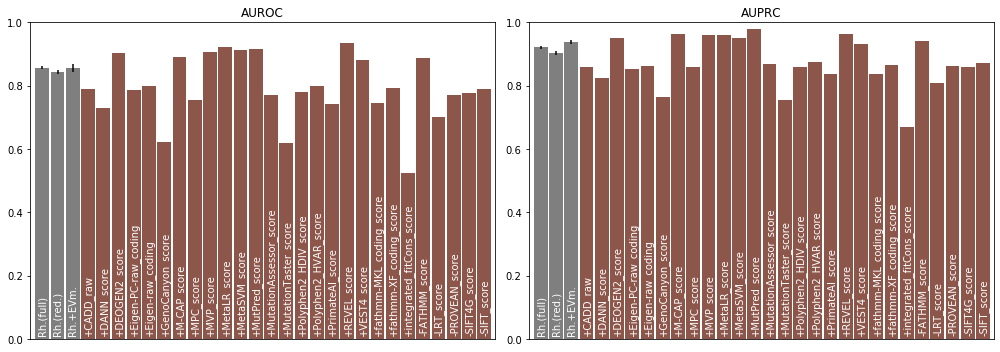

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

d = rhapsody_metrics
methods = sorted(list(score_metrics.keys()))
opts = {'width': .9}

for i, stat in enumerate(['AUROC', 'AUPRC']):
    
    ax = axes[i]
    ax.set_title(stat)

    # left bars - Rhapsody
    x = np.arange(3)
    y = [d[v][f'mean {stat}'][0] for v in ['full', 'reduced', 'EVmut']]
    yerr = [d[v][f'mean {stat}'][1] for v in ['full', 'reduced', 'EVmut']]
    h0 = ax.bar(x, y, yerr=yerr, color='C7', **opts)

    # right bars - other methods
    x = np.arange(len(methods)) + 3
    y = [score_metrics[m][stat] for m in methods]
    ax.bar(x, y, color='C5', **opts)

    n_bars = len(methods) + 3
    ax.set_ylim(0, 1)
    ax.set_xlim(-.8, n_bars-.3)
    
    labels = ['Rh.(full)', 'Rh.(red.)', 'Rh.+EVm.']
    labels.extend(methods)
    x = np.arange(n_bars)
    for i,s in enumerate(labels):
        ax.text(x[i]-0.3, .01, s, color='w', rotation=90, va='bottom', size='10')

    ax.set_xticks([])
    
fig.tight_layout()
fig.savefig('local/figures/AUROC_AUPRC.png', dpi=300);

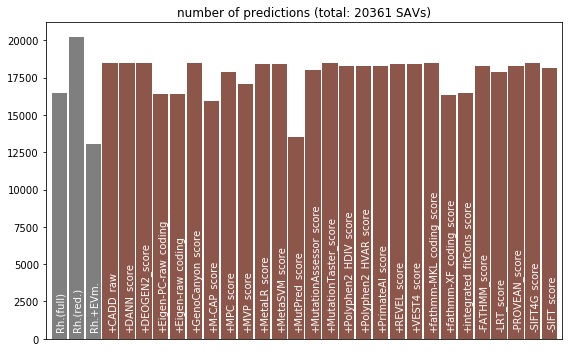

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))

d = rhapsody_metrics
methods = sorted(list(score_metrics.keys()))
opts = {'width': .9}

n_tot = sum(ID['true_label'] != -1)
ax.set_title(f'number of predictions (total: {n_tot} SAVs)')

# left bars - Rhapsody
x = np.arange(3)
y = [d[v]['dataset size'] for v in ['full', 'reduced', 'EVmut']]
h0 = ax.bar(x, y, color='C7', **opts)

# right bars - other methods
x = np.arange(len(methods)) + 3
y = [score_metrics[m]['dataset size'] for m in methods]
ax.bar(x, y, color='C5', **opts)

n_bars = len(methods) + 3
ax.set_xlim(-.8, n_bars-.3)

labels = ['Rh.(full)', 'Rh.(red.)', 'Rh.+EVm.']
labels.extend(methods)
x = np.arange(n_bars)
for i,s in enumerate(labels):
    ax.text(x[i]-0.2, 500, s, color='w', rotation=90, va='bottom', size='10')

ax.set_xticks([])
    
fig.tight_layout()
fig.savefig('local/figures/dataset_size.png', dpi=300);

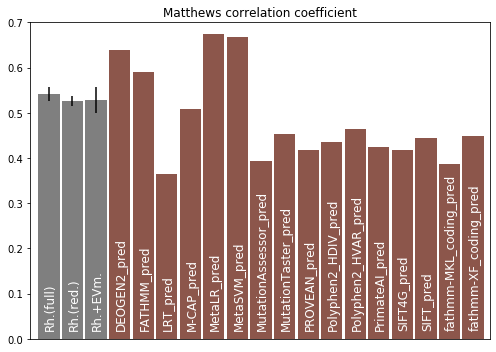

In [15]:
fig, ax = plt.subplots(figsize=(7, 5))

d = rhapsody_metrics
methods = sorted(list(class_metrics.keys()))
opts = {'width': .9}

ax.set_title('Matthews correlation coefficient')

# left bars - Rhapsody
x = np.arange(3)
y = [d[v][f'mean MCC'][0] for v in ['full', 'reduced', 'EVmut']]
yerr = [d[v][f'mean MCC'][1] for v in ['full', 'reduced', 'EVmut']]
h0 = ax.bar(x, y, yerr=yerr, color='C7', **opts)

# right bars - other methods
x = np.arange(len(methods)) + 3
y = [class_metrics[m]['MCC'] for m in methods]
ax.bar(x, y, color='C5', **opts)

n_bars = len(methods) + 3
ax.set_ylim(0, .7)
ax.set_xlim(-.8, n_bars-.3)

labels = ['Rh.(full)', 'Rh.(red.)', 'Rh.+EVm.']
labels.extend(methods)
x = np.arange(n_bars)
for i,s in enumerate(labels):
    ax.text(x[i]-0.2, .02, s, color='w', rotation=90, va='bottom', size='12')

ax.set_xticks([])
    
fig.tight_layout()
fig.savefig('local/figures/MCC.png', dpi=300);

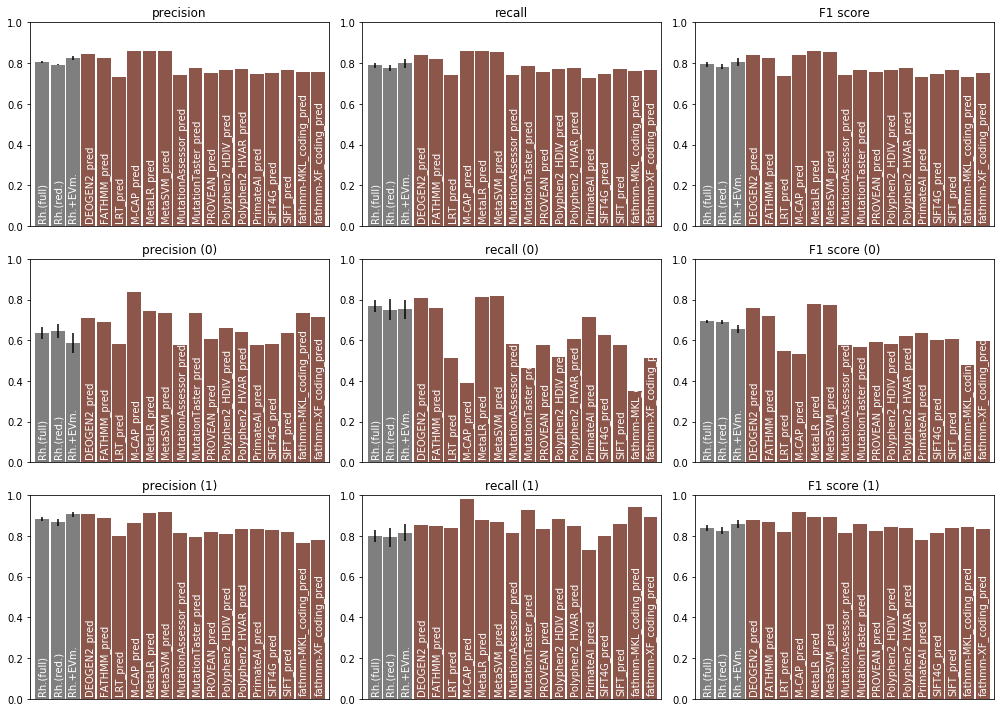

In [16]:
stats = ['precision', 'recall', 'F1 score',
         'precision (0)', 'recall (0)', 'F1 score (0)', 
         'precision (1)', 'recall (1)', 'F1 score (1)']

fig, axes = plt.subplots(3, 3, figsize=(14, 10))

d = rhapsody_metrics
methods = sorted(list(class_metrics.keys()))
opts = {'width': .9}

for i, stat in enumerate(stats):
    
    ax = axes[int(i/3), i%3]
    ax.set_title(stat)

    # left bars - Rhapsody
    x = np.arange(3)
    y = [d[v][f'mean {stat}'][0] for v in ['full', 'reduced', 'EVmut']]
    yerr = [d[v][f'mean {stat}'][1] for v in ['full', 'reduced', 'EVmut']]
    h0 = ax.bar(x, y, yerr=yerr, color='C7', **opts)

    # right bars - other methods
    x = np.arange(len(methods)) + 3
    y = [class_metrics[m][stat] for m in methods]
    ax.bar(x, y, color='C5', **opts)

    n_bars = len(methods) + 3
    ax.set_ylim(0, 1)
    ax.set_xlim(-.8, n_bars-.3)
    
    labels = ['Rh.(full)', 'Rh.(red.)', 'Rh.+EVm.']
    labels.extend(methods)
    x = np.arange(n_bars)
    for i,s in enumerate(labels):
        ax.text(x[i]-0.3, .02, s, color='w', rotation=90, va='bottom', size='10')

    ax.set_xticks([])
    
fig.tight_layout()
fig.savefig('local/figures/prec_rec_f1.png', dpi=300);